## Navigate to Project Folder

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd 'drive/Shareddrives/ML PROJECT'
%cd ..
%ls

G:\Shared drives\ML PROJECT\FP_Nehal_Anthony_Alex
 Volume in drive G is Google Drive
 Volume Serial Number is 1983-1116

 Directory of G:\Shared drives\ML PROJECT\FP_Nehal_Anthony_Alex

2022-04-26  03:33 PM    <DIR>          .
2022-04-26  03:26 PM    <DIR>          ..
2022-04-26  03:13 PM    <DIR>          EDA
2022-04-26  03:38 PM    <DIR>          Original_data
2022-04-26  03:42 PM    <DIR>          pseudo_resnet20
2022-04-26  03:31 PM                 0 Readme.txt
2022-04-26  03:14 PM    <DIR>          ResNet20
2022-04-26  03:51 PM    <DIR>          Resnet50
2022-04-26  03:30 PM    <DIR>          SVM
2022-04-26  03:55 PM    <DIR>          VanillaCNN
               1 File(s)              0 bytes
               9 Dir(s)  18,160,693,248 bytes free


## Import libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

# Unused so far
import pickle
from pathlib import Path
from skimage import io

# import Image from PIL
from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import train_test_split from sklearn's model selection module
from sklearn.model_selection import train_test_split

# import SVC from sklearn's svm module
from sklearn.svm import SVC

# import accuracy_score from sklearn's metrics module
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix

# Deep learning libraries
import tensorflow as tf
# import keras library
import keras

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.layers import Activation



In [3]:
# Function for natural sort to make things chronological
# https://stackoverflow.com/questions/4836710/is-there-a-built-in-function-for-string-natural-sort
import re
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

# The image files we use
img_files = os.listdir('Original_data/dataset_alternate/dataset_1/')
print('# of images: ', len(img_files))
labels_ = pd.read_csv('Original_data/dataset_alternate/labels_1.csv').sort_values(by='id')
labels_ = labels_.astype(int, copy=True, errors='raise')
labels = labels_['genus'].values


# Show the output of the natural sort so the plots will be chronological
# file_list2 = [f for f in listdir() if isfile(join(f)) if '.csv' in f]
img_files2 = natural_sort(img_files)

# of images:  1654


## Making the Pipeline to create black and white images, and rotated/cropped

In [4]:
# image_paths = ['Original_data/dataset_alternate/dataset_1/' + im for im in img_files2]

def image_processing(path):
    img = Image.open(path)

    # create the paths to save files to
    bw_path = "Augmented_data/bw/bw_{}.jpg".format(path.stem)
    rcz_path = "Augmented_data/rcz/rcz_{}.jpg".format(path.stem)

    # print("Creating grayscale version of {} and saving to {}.".format(path, bw_path))
    bw = img.convert("L").resize((100, 100))
    bw.save(bw_path)
    
    # print("Creating rotated, cropped, and zoomed version of {} and saving to {}.".format(path, rcz_path))
    rcz = bw.rotate(180).crop([20, 20, 80, 80]).resize((100, 100))
    rcz.save(rcz_path)

# # # for loop over the image paths
# for img_path in image_paths:
#     image_processing(Path(img_path))

In [7]:
# Sort BW and rcz after they are created

# bw_images = natural_sort(os.listdir('Augmented_data/bw/'))
# rcz_images = natural_sort(os.listdir('Augmented_data/rcz/'))

# print(rcz_images[0:10])
# len(rcz_images)

## Deep Learning Approach to Solving this Problem

### Import Bee Images, Train, test, split

In [8]:
# 4. Importing the image data
# create empty list
image_list_bw = []
image_list_rcz = []
image_list = []
bw = False
rcz = False
for i in range(labels.shape[0]):
    # load image
    if bw == True:
        img_bw = io.imread('Augmented_data/bw/'+bw_images[i].format(i)).astype(np.float64)  
    if rcz == True:
        img_rcz = io.imread('Augmented_data/rcz/'+rcz_images[i].format(i)).astype(np.float64)
    else:
        img = io.imread('Original_data/dataset_alternate/dataset_1/'+img_files2[i].format(i)).astype(np.float64)
      
    if bw == True:
        image_list_bw.append(img_bw)
    if rcz == True:
        image_list_rcz.append(img_rcz)
    
    else:
        image_list.append(img)
    



# convert image list to single array
if bw == False and rcz==False:
    X_ = np.array(image_list)
    X = X_/255
    # assign the genus label values to y
    y = labels

# Only for augmentation
if bw == True and rcz == True:
    X_ = np.concatenate([image_list_bw, image_list_rcz])
    y = np.concatenate([labels,labels])
    X = X_/255
    X = np.expand_dims(X, axis=-1)
    
print("Full X shape", X.shape)

# print value counts for genus
print(np.unique(y, return_counts=True))

# 5 SPLITTING
# split out evaluation sets (x_eval and y_eval)
x_interim, x_eval, y_interim, y_eval = train_test_split(X,y, 
                                                        test_size=0.2, 
                                                        random_state=52)

# split remaining data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_interim, 
                                                    y_interim, 
                                                    test_size=0.2, 
                                                    random_state=52)

# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')


Full X shape (1654, 50, 50, 3)
(array([0, 1]), array([827, 827], dtype=int64))
x_train shape: (1058, 50, 50, 3)
1058 train samples
265 test samples
331 eval samples


### Standardize Images

In [ ]:
# 6 , Normalize the image data
# initialize standard scaler
# ss = StandardScaler()

# def scale_features(train_features, test_features):
#     for image in train_features:
#         # for each channel, apply standard scaler's fit_transform method
#         for channel in range(image.shape[2]):
#             image[:, :, channel] = ss.fit_transform(image[:, :, channel])
#     for image in test_features:
#         # for each channel, apply standard scaler's transform method
#         for channel in range(image.shape[2]):
#             image[:, :, channel] = ss.transform(image[:, :, channel])

# # apply scale_features to four sets of features
# scale_features(x_interim, x_eval)
# scale_features(x_train, x_test)

## Show some Bees

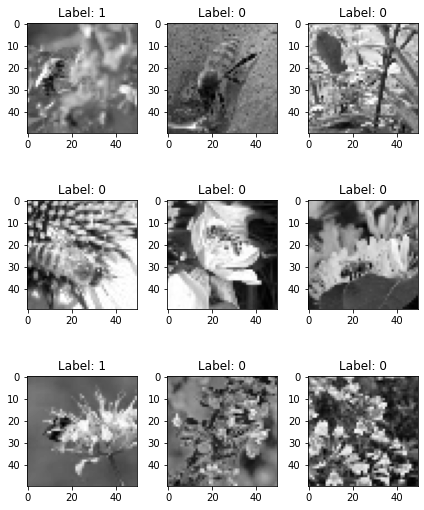

In [9]:
# Visualize

num = 9  # number of images to visualize
images_ = x_train[10:19]
labels_ = y_train[10:19]

num_row = 3
num_col = 3

fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2.5*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images_[i][:,:,0], cmap='gray')
    ax.set_title('Label: {}'.format(labels_[i]))
plt.tight_layout()
plt.show()

## Vanilla TF Model

In [12]:
#7 Model Building Part - 1 
# set model constants
num_classes = 1
input_shape = (50, 50, 3)
if bw == True:
    input_shape = (100, 100, 1)
    kernel_ = (3,3)
    strides_ = (2,2)
kernel_ = (2,2)
strides_ = (1,1)
# define model as Sequential
model = Sequential()
model.add(keras.Input(shape=input_shape))
model.add(ZeroPadding2D((1,1)))
# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_, strides_, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
# 8 Model Building part -2 
# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_, strides_))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_, strides_))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
# necessary flatten step preceeding dense layer
model.add(Flatten())

# add dropout to prevent over fitting
model.add(Dropout(0.5))

# # fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))


# prediction layers
model.add(Dense(num_classes, activation='sigmoid', name='prediction'))

# show model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_2 (ZeroPaddi  (None, 52, 52, 3)        0         
 ng2D)                                                           
                                                                 
 conv2d (Conv2D)             (None, 51, 51, 32)        416       
                                                                 
 batch_normalization (BatchN  (None, 51, 51, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 51, 51, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                      

In [13]:
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1]), array([131, 134], dtype=int64))

In [14]:
# 9 Compile and train model
model.compile(
    # set the loss as binary_crossentropy
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=False),
    # set the optimizer as stochastic gradient descent
    optimizer= tf.keras.optimizers.Adamax(learning_rate=0.01),
    # set the metric as accuracy
    metrics=tf.keras.metrics.BinaryAccuracy(), 
    
)

# train the model using the first ten observations of the train and test sets
history = model.fit(x_train, y_train, epochs=100, verbose=0,
          validation_data=(x_test, y_test), batch_size=128)

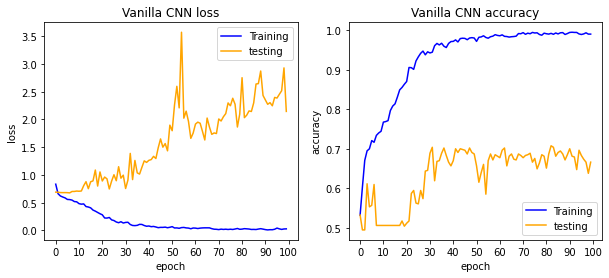

In [170]:
history.history.keys()

train_loss = history.history['loss']
train_acc = history.history['binary_accuracy']
test_loss = history.history['val_loss']
test_acc = history.history['val_binary_accuracy']

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].plot(train_loss, label = "Training", color='blue')
ax[1].plot(train_acc, label = "Training", color='blue')
ax[0].plot(test_loss, label = "testing", color='orange')
ax[1].plot(test_acc, label = "testing", c='orange')
ax[1].set_xticks(np.arange(0,101,10))
ax[0].set_xticks(np.arange(0,101,10))
ax[0].set_xlabel('epoch')
ax[1].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')
ax[0].set_title('Vanilla CNN loss')
ax[1].set_title('Vanilla CNN accuracy')
ax[0].legend()
ax[1].legend();

In [171]:
# 10 Load pre-trained model 
# load pre-trained model
# pretrained_cnn = keras.models.load_model('datasets/pretrained_model.h5')

# evaluate model on test set
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("")

# evaluate model on holdout set
eval_score = model.evaluate(x_eval, y_eval, verbose=0)
# print loss score
print('Eval loss:', eval_score[0])
# print accuracy score
print('Eval accuracy:', eval_score[1])

Test loss: 2.1451125144958496
Test accuracy: 0.6660377383232117

Eval loss: 2.5878970623016357
Eval accuracy: 0.6510574221611023


In [20]:
# predicted probabilities for x_eval
y_proba = model.predict(x_eval)
print(y_proba.shape)
print("")
# predicted classes for x_eval
print("")
y_pred = np.round(y_proba).astype('int')

(662, 1)


